# Part A and Part C of Assignment 1
By Naveena Chatti

In [1]:
pip install torch torchvision matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
# Define transformations
transform = transforms.Compose([transforms.ToTensor()])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:06<00:00, 1651222.01it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 159789.39it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1297556.18it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5293283.90it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)


In [5]:

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=False)



In [6]:
all_labels = set()

# Iterate through the training data loader
for i, (x_batch, y_batch) in enumerate(train_loader):
    all_labels.update(y_batch.numpy())
    if i >= 100:  # Limit to first 100 batches for this check
        break

print(f"Unique labels seen: {all_labels}")


Unique labels seen: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [14]:
  # Define the neural network architecture
class NeuralNetwork:
    def __init__(self, input_size, hidden_size=100, output_size=10):
        self.W1 = torch.randn(hidden_size, input_size, device=device) * np.sqrt(2. / input_size)  # He initialization
        self.W2 = torch.randn(output_size, hidden_size, device=device) * np.sqrt(2. / hidden_size)  # He initialization
        self.b1 = torch.zeros(hidden_size, 1, device=device)  # Bias for layer 1
        self.b2 = torch.zeros(output_size, 1,device=device) # Bias for layer 2

        self.device=device
    def to_device(self, device):
        self.W1 = self.W1.to(device)
        self.W2 = self.W2.to(device)
        self.b1 = self.b1.to(device)
        self.b2 = self.b2.to(device)

    def relu(self, x):
        return x.clamp(min=0)

    def softmax(self, x):
        max_x = torch.max(x, dim=1, keepdim=True).values
        exp_x = torch.exp(x - max_x)  # Subtract max for numerical stability
        return exp_x / exp_x.sum(dim=1, keepdim=True)

    def forward(self, x):
    # Ensure x is reshaped to (batch_size, 784)
        x = x.view(x.size(0), -1)  # Flatten the input
        self.z1 = self.W1.mm(x.t()) + self.b1  # [hidden_size, batch_size]
        self.a1 = self.relu(self.z1)  # Apply activation
        self.z2 = self.W2.mm(self.a1) + self.b2  # [output_size, batch_size]

    # Return z2 transposed to match [batch_size, output_size]

        return self.z2  # Transpose to [batch_size, output_size]

    def backward(self, x, y, learning_rate):
        m = x.size(0)  # Batch size
        output = self.forward(x)  # Forward pass to get the output


        probabilities = self.softmax(output.t())

        # Cross-Entropy Loss for one-hot encoded targets
        loss = -(y * torch.log(probabilities+ 1e-12)).sum(dim=1).mean()

        # Gradients for W2 and b2 (adjusted for one-hot encoded targets)
        grad_output = probabilities - y
        grad_output /= m

        grad_W2 = grad_output.t().mm(self.a1.t())
        grad_b2 = grad_output.sum(dim=0, keepdim=True).t()

        hidden_loss = grad_output.mm(self.W2)
        grad_a1 = hidden_loss.t() * (self.z1 > 0).float()

        # Gradients for W1 and b1
        grad_W1 = grad_a1.mm(x.view(x.size(0), -1))
        grad_b1 = grad_a1.sum(dim=1, keepdim=True)

        # Update weights and biases
        self.W1 -= learning_rate * grad_W1
        self.b1 -= learning_rate * grad_b1
        self.W2 -= learning_rate * grad_W2
        self.b2 -= learning_rate * grad_b2

In [ ]:
  # Defined a train_network method which I did not use for training my model.
  # I have chosen to include this code as a part of the snippet that I used to call my NeuralNetwork.
  # This is to suggest an alternative way.
  def train_network(network, epochs, batch_size, learning_rate):
    for epoch in range(epochs):
        for inputs, targets in tqdm(train_loader, desc="Training batches", leave=False):

            # Print the raw targets
            inputs = inputs.view(inputs.size(0), -1).to(device)  # Flatten the inputs
            targets = targets.to(device)
            # Print the targets before one-hot encoding

            # Convert targets to one-hot encoding
            targets_one_hot = torch.eye(10, device=device)[targets]

            # Forward pass
            output = network.forward(inputs)

            # Backward pass
            loss = network.backward(inputs, targets_one_hot, learning_rate)






In [17]:
def evaluate_network(network):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.view(inputs.size(0), -1).to(device)  # Flatten inputs for the network
            targets = targets.to(device)  # Move targets to the same device as the model

            outputs = network.forward(inputs)
            # Transpose the outputs to get the correct shape (batch_size, num_classes)
            outputs = outputs.T
            _, predicted = torch.max(outputs, 1)

            total += targets.size(0)
            correct += (predicted == targets).sum().item()  # No need to move targets again

    accuracy = correct / total if total > 0 else 0  # Prevent division by zero
    print(f"Test Accuracy: {accuracy:.4f}")  # Optional print statement
    return accuracy


In [ ]:
!pip install tqdm


# Part A Mini Batches batch size 50

In [ ]:
# Ensure all weights and biases are on CPU
import time
import torch
from tqdm import tqdm  # Import tqdm for the progress bar
# Create data loaders
batch_size=50
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Start timing
start_time = time.time()

# Experiment: Set Batch Size

total_epochs = 150
check_epochs = [25, 50, 100, 150]  # Epochs at which to check accuracy

# Initialize the network once for the current batch size
network = NeuralNetwork(input_size=784, hidden_size=100, output_size=10)
network.to_device(device)
results2 = []

# Train for 150 epochs
for epoch in range(1, total_epochs + 1):
    # Use tqdm for batch processing within the epoch
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch}/{total_epochs}") as pbar:
        for inputs, targets in train_loader:
            # Move inputs and targets to the device
            inputs = inputs.to(device)  # Move inputs to GPU
            targets = targets.to(device)  # Move targets to GPU

            # One-hot encoding for targets
            targets_one_hot = torch.eye(10, device=device)[targets]  # One-hot encoding

            # Forward pass
            output = network.forward(inputs)

            # Backward pass
            network.backward(inputs, targets_one_hot, learning_rate=0.01)

            pbar.update(1)  # Update progress bar

    # Check accuracy at specified epochs
    if epoch in check_epochs:
        accuracy = evaluate_network(network)
        results2.append((batch_size, epoch, accuracy))

# Print final accuracies
print(f"Final accuracies: {results2}")

# End timing
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")


Epoch 25/150: 100%|██████████| 1200/1200 [00:11<00:00, 108.42it/s]


Test Accuracy: 0.9590


Epoch 50/150: 100%|██████████| 1200/1200 [00:11<00:00, 106.04it/s]


Test Accuracy: 0.9707


Epoch 100/150: 100%|██████████| 1200/1200 [00:10<00:00, 112.71it/s]


Test Accuracy: 0.9781


Epoch 150/150: 100%|██████████| 1200/1200 [00:11<00:00, 107.31it/s]


Test Accuracy: 0.9789
Final accuracies: [(50, 25, 0.959), (50, 50, 0.9707), (50, 100, 0.9781), (50, 150, 0.9789)]
Elapsed time: 1631.95 seconds


The accuracy has improved to 0.9590,0.9707,0.9781,0.9789 for 25,50,100,150 epochs with learning rate 0.01 and batch_size=50

# Part C: Using both Relu and Tanh as activation functions

Epoch [1/150], Training Accuracy: 0.8579
Epoch [2/150], Training Accuracy: 0.8841
Epoch [3/150], Training Accuracy: 0.8941
Epoch [4/150], Training Accuracy: 0.9028
Epoch [5/150], Training Accuracy: 0.9079
Epoch [6/150], Training Accuracy: 0.9119
Epoch [7/150], Training Accuracy: 0.9155
Epoch [8/150], Training Accuracy: 0.9191
Epoch [9/150], Training Accuracy: 0.9215
Epoch [10/150], Training Accuracy: 0.9238
Epoch [11/150], Training Accuracy: 0.9266
Epoch [12/150], Training Accuracy: 0.9288
Epoch [13/150], Training Accuracy: 0.9303
Epoch [14/150], Training Accuracy: 0.9323
Epoch [15/150], Training Accuracy: 0.9345
Epoch [16/150], Training Accuracy: 0.9359
Epoch [17/150], Training Accuracy: 0.9384
Epoch [18/150], Training Accuracy: 0.9402
Epoch [19/150], Training Accuracy: 0.9416
Epoch [20/150], Training Accuracy: 0.9437
Epoch [21/150], Training Accuracy: 0.9447
Epoch [22/150], Training Accuracy: 0.9454
Epoch [23/150], Training Accuracy: 0.9464
Epoch [24/150], Training Accuracy: 0.9472
E

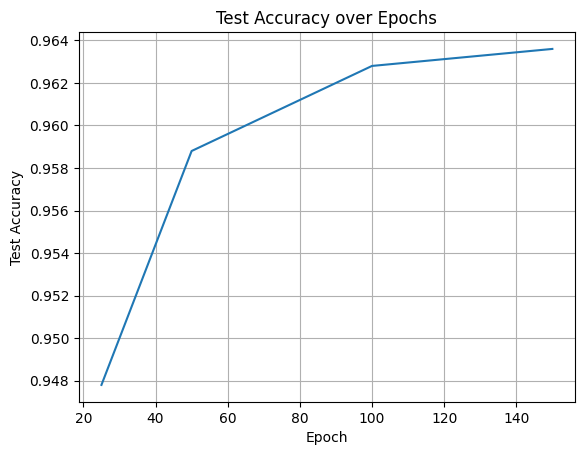

In [13]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the neural network architecture
class NeuralNetwork:
    def __init__(self, input_size, hidden_size=100, output_size=10):
        self.W1 = torch.randn(hidden_size, input_size, device=device) * np.sqrt(2. / input_size)
        self.W2 = torch.randn(output_size, hidden_size, device=device) * np.sqrt(2. / hidden_size)
        self.b1 = torch.zeros(hidden_size, 1, device=device)
        self.b2 = torch.zeros(output_size, 1, device=device)

    def to_device(self, device):
        self.W1 = self.W1.to(device)
        self.b1 = self.b1.to(device)
        self.W2 = self.W2.to(device)
        self.b2 = self.b2.to(device)

    def relu(self, x):
        return x.clamp(min=0)

    def tanh(self, x):
        return torch.tanh(x)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        self.z1 = self.W1.mm(x.t()) + self.b1  # First layer
        self.a1 = self.tanh(self.z1)  # Tanh activation
        self.z2 = self.W2.mm(self.a1) + self.b2  # Second layer
        self.a2 = self.relu(self.z2)  # ReLU activation
        return self.a2.t()  # Transpose to [batch_size, output_size]

    def backward(self, x, y, learning_rate):
        m = x.size(0)
        output = self.forward(x)

        # Calculate loss (Mean Squared Error for simplicity)
        loss = - (y * torch.log(output + 1e-12)).sum(dim=1).mean()

        # Backward pass
        grad_output = output - y
        grad_output /= m

        grad_W2 = grad_output.t().mm(self.a1.t())
        grad_b2 = grad_output.sum(dim=0, keepdim=True).t()

        hidden_loss = grad_output.mm(self.W2)
        grad_a1 = hidden_loss.t() * (self.z1 > 0).float()

        grad_W1 = grad_a1.mm(x.view(x.size(0), -1))
        grad_b1 = grad_a1.sum(dim=1, keepdim=True)

        # Update weights and biases
        self.W1 -= learning_rate * grad_W1
        self.b1 -= learning_rate * grad_b1
        self.W2 -= learning_rate * grad_W2
        self.b2 -= learning_rate * grad_b2

# Evaluation function
def evaluate_model(model, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model.forward(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return correct / total

# Create data loaders
batch_size = 50
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Start timing
start_time = time.time()

# Parameters
total_epochs = 150
check_epochs = [25, 50, 100, 150]  # Epochs at which to check accuracy

# Initialize the network
network = NeuralNetwork(input_size=784, hidden_size=100, output_size=10)
network.to_device(device)
results4 = []

# Train for 150 epochs
for epoch in range(1, total_epochs + 1):
    for inputs, targets in train_loader:
        inputs = inputs.to(device)  # Move inputs to GPU
        targets = targets.to(device)  # Move targets to GPU

        # One-hot encoding for targets
        targets_one_hot = torch.eye(10, device=device)[targets]  # One-hot encoding

        # Forward pass
        output = network.forward(inputs)

        # Backward pass
        network.backward(inputs, targets_one_hot, learning_rate=0.01)

    # Calculate training accuracy
    train_accuracy = evaluate_model(network, train_loader)
    print(f'Epoch [{epoch}/{total_epochs}], Training Accuracy: {train_accuracy:.4f}')

    # Check accuracy at specified epochs
    if epoch in check_epochs:
        test_accuracy = evaluate_model(network, test_loader)
        results4.append((batch_size, epoch, test_accuracy))
        print(f'Epoch [{epoch}], Test Accuracy: {test_accuracy:.4f}')

# Print final test accuracies
print(f"Final test accuracies: {results4}")

# End timing
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

# Optionally plot results
plt.plot([x[1] for x in results4], [x[2] for x in results4])
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy over Epochs')
plt.grid()
plt.show()


# Part A SGD Batch size =1

In [19]:
import time
import torch
from tqdm import tqdm  # Import tqdm for the progress bar
train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Start timing
start_time = time.time()

# Experiment: Set Batch Size
batch_size = 1  # Fixed batch size
total_epochs = 150
check_epochs = [25,50,100,150]  # Epochs at which to check accuracy

# Initialize the network once for the current batch size
network = NeuralNetwork(input_size=784, hidden_size=100, output_size=10)
network.to_device(device)
results5 = []
# Train for 150 epochs
for epoch in range(1, total_epochs + 1):
    # Use tqdm for batch processing within the epoch
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch}/{total_epochs}") as pbar:
        for inputs, targets in train_loader:
            # Move inputs and targets to the device
            inputs = inputs.to(device)  # Move inputs to GPU
            targets = targets.to(device)  # Move targets to GPU

            # One-hot encoding for targets
            targets_one_hot = torch.eye(10, device=device)[targets]  # One-hot encoding

            # Forward pass
            output = network.forward(inputs)

            # Backward pass
            network.backward(inputs, targets_one_hot, learning_rate=0.01)

            pbar.update(1)  # Update progress bar

    # Check accuracy at specified epochs
    if epoch in check_epochs:
        accuracy = evaluate_network(network)
        results5.append((batch_size, epoch, accuracy))

# Print final accuracies
print(f"Final accuracies: {results5}")

# End timing
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")


Epoch 25/150: 100%|██████████| 60000/60000 [00:38<00:00, 1557.19it/s]


Test Accuracy: 0.9817


Epoch 50/150: 100%|██████████| 60000/60000 [00:38<00:00, 1571.01it/s]


Test Accuracy: 0.9820


Epoch 100/150: 100%|██████████| 60000/60000 [00:38<00:00, 1544.22it/s]


Test Accuracy: 0.9822


Epoch 150/150: 100%|██████████| 60000/60000 [00:39<00:00, 1525.69it/s]


Test Accuracy: 0.9827
Final accuracies: [(1, 25, 0.9817), (1, 50, 0.982), (1, 100, 0.9822), (1, 150, 0.9827)]
Elapsed time: 5818.16 seconds
